<a href="https://colab.research.google.com/github/allesrebel/physics-guided-entropy/blob/main/PGENN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Conda on Google Colab

<!-- By Jaime Rodríguez-Guerra <@jaimergp>. Last modified 2021.08.04 -->

`condacolab` simplifies the setup as much as possible, but there are some gotchas.

**⚠️ Read this before continuing!**

* The `condacolab` commands need to be run the first Code cell!
* Once you run `condacolab.install()`, the Python kernel will be restarted. This is **normal and expected**. After that, you can continue running the cells below like normal.
* Do not use the `Run all` option. Run the `condacolab` cell _individually_ and wait for the kernel to restart. **Only then**, you can run all cells if you want.
* You can only use the `base` environment. Do not try to create new ones; instead update `base` with either:
  * `conda install <packages>`
  * `conda env update -n base -f environment.yml`
* If you want to use GPUs, make sure you are using such an instance before starting!
* If you get an error, please raise an issue [here](https://github.com/jaimergp/condacolab/issues).

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:37
🔁 Restarting kernel...


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


# PGENN
After Conda is online - we can now start installing the dependencies for this tool. We'll install the tools and featurize a bunch of PDB files. We'll extract spacial features using existing featurizers built into deepchem, and couple that with a computationally expensive method called VM2.

In [3]:
# To use PDB Fixer inside RDKit
!mamba install -q numpy openmm pdbfixer vina deepchem pytorch
# the primary deeplearning framework + tools
!pip install -q mdtraj nglview pymatgen dgllife torch-geometric pytorch_lightning rdkit-pypi
# To get DGL (Deep Graph Library)
!pip install -q dgl dglgo -f https://data.dgl.ai/wheels/repo.html


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.25.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

  Package                        Version  Build                Channel                   Size
───────────────────

In [4]:
# basic utils we'll be using
from collections import defaultdict

# for Deep learning ML Code
import torch
import deepchem
from dgl.nn import GraphConv

# some RDKit stuff + other utils
from rdkit import Chem
import tempfile
from deepchem.utils import download_url, load_from_disk, docking_utils
import numpy
from pdbfixer import PDBFixer
from openmm.app import PDBFile
import pandas

# for os stuff/paths
import os
import time

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


We'll start by pulling the dataset from Mobley's lab github. These will be partially docked versions of the systems. We'll validate the dock later using Deepchem's built in Autodocker, but for now, we'll clean up all the items and generate structures for us to use later.

In [4]:
# Grab the raw dataset from Mobley Lab's Github
if not os.path.exists('benchmarksets'):
  !git clone https://github.com/MobleyLab/benchmarksets.git

# create a list of guests we can featurize
guests_vina = []
host = None
for _, _, files in os.walk('benchmarksets/input_files/cd-set1/pdb'):
  for file in files:
    if 'guest' in file:
      guests_vina.append( os.path.splitext(file)[0] )
    else:
      host = os.path.splitext(file)[0]

for root, directory, files in os.walk('benchmarksets/input_files/cd-set1/pdb'):

  # pull out the host, we'll need to have it fixed up
  host_pdb_fixed = None
  for file in files:
    if host in file:
      fixer = PDBFixer(os.path.join(root,file))
      PDBFile.writeFile(fixer.topology, fixer.positions, open(os.path.join(root,file), 'w'))
      host_pdb_fixed = os.path.join(root,file)

  for file in files:
    if 'guest' in file:
      fixer = PDBFixer(os.path.join(root,file))
      PDBFile.writeFile(fixer.topology, fixer.positions, open(os.path.join(root,file), 'w'))
      
      try:
        # This method creates 2 PDB files, cleaned up (ligand_guest#.pdb) which contains the ligand and (guest#.pdb), which contains the host
        docking_utils.prepare_inputs(host_pdb_fixed, os.path.join(root,file), replace_nonstandard_residues=False,
                              remove_heterogens=False, remove_water=False,
                              add_hydrogens=False, pdb_name=os.path.splitext(file)[0])
      except Exception as e:
        print(f'{e} - {file} Failed to be Cleaned') 

# Define simple featurizer function, to extract features from a 
# docked version of the system
def compute_features_vina(featurizer, ligand):
  # Compute features for a given complex
  protein_file = f'{ligand}.pdb'
  ligand_file = f'ligand_{ligand}.pdb'

  # Let's find good docks/poses with deepchem's auto docker
  docker = deepchem.dock.docking.Docker(
      pose_generator=deepchem.dock.VinaPoseGenerator())
  [p, l], score = next( docker.dock(
      molecular_complex = (protein_file, ligand_file),
      use_pose_generator_scores = True) )

  # create a single complex, which we will run through the featurizer  
  complex_mol = Chem.CombineMols(p, l)
  Chem.SanitizeMol(complex_mol)

  # just to checkout the SMILES
  print(f'{ligand} via vina', Chem.MolToSmiles(complex_mol))

  # Featurize the Docked Complex
  return featurizer.featurize(complex_mol)

# Just to see all the PDB files we've just generated
!ls *.pdb

Cloning into 'benchmarksets'...
remote: Enumerating objects: 2716, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 2716 (delta 5), reused 10 (delta 5), pack-reused 2696
Receiving objects: 100% (2716/2716), 133.08 MiB | 26.50 MiB/s, done.
Resolving deltas: 100% (1633/1633), done.
Checking out files: 100% (747/747), done.


guest-1.pdb    guest-s13.pdb  ligand_guest-1.pdb    ligand_guest-s13.pdb
guest-2.pdb    guest-s14.pdb  ligand_guest-2.pdb    ligand_guest-s14.pdb
guest-3.pdb    guest-s15.pdb  ligand_guest-3.pdb    ligand_guest-s15.pdb
guest-4.pdb    guest-s16.pdb  ligand_guest-4.pdb    ligand_guest-s16.pdb
guest-5.pdb    guest-s17.pdb  ligand_guest-5.pdb    ligand_guest-s17.pdb
guest-6.pdb    guest-s18.pdb  ligand_guest-6.pdb    ligand_guest-s18.pdb
guest-7.pdb    guest-s19.pdb  ligand_guest-7.pdb    ligand_guest-s19.pdb
guest-8.pdb    guest-s20.pdb  ligand_guest-8.pdb    ligand_guest-s20.pdb
guest-s10.pdb  guest-s21.pdb  ligand_guest-s10.pdb  ligand_guest-s21.pdb
guest-s11.pdb  guest-s22.pdb  ligand_guest-s11.pdb  ligand_guest-s22.pdb
guest-s12.pdb  guest-s9.pdb   ligand_guest-s12.pdb  ligand_guest-s9.pdb


Now we'll strip all the docking information/position information by converting to a SMILES for both host and guest, then combining them.

In [5]:
# Grab the raw dataset from Mobley Lab's Github
if not os.path.exists('benchmarksets'):
  !git clone https://github.com/MobleyLab/benchmarksets.git

# create a lookup table for the ligand SMILES
ligand_lut = \
{
	'guest-1': 'CCCC[NH3+]',
	'guest-2': 'CCCCCC[NH3+]',
	'guest-3': 'CCCCCCCC[NH3+]',
	'guest-4': 'OC1CCCC1',
	'guest-5': 'OC1CCCCCC1',
	'guest-6': 'CCCC([O-])=O',
	'guest-7': 'CCCCCC([O-])=O',
	'guest-8': 'CCCCCCCC([O-])=O',
	'guest-s9': 'CCCC[NH2+]C',
	'guest-s10': 'CCCC(C)[NH3+]',
	'guest-s11': 'CCCCC[NH3+]',
	'guest-s12': 'CCCCCC[NH2+]C',
	'guest-s13': 'CCCCCC(C)[NH3+]',
	'guest-s14': 'CCCCCCC[NH3+]',
	'guest-s15': 'CCCCCCC(C)[NH3+]',
	'guest-s16': 'OC1CCC1',
	'guest-s17': 'OC1CCCCCCC1',
	'guest-s18': 'CCCCC([O-])=O',
	'guest-s19': 'CCC/C=C/C([O-])',
	'guest-s20': 'CC/C=C/CC([O-])',
	'guest-s21': 'CCCCCCC([O-])=O',
	'guest-s22': '[O-]C(=O)CCCCC=C'
}

host_smiles = 'C([C@@H]1[C@@H]2[C@@H]([C@H]([C@H](O1)O[C@@H]3[C@H](O[C@@H]([C@@H]([C@H]3O)O)O[C@@H]4[C@H](O[C@@H]([C@@H]([C@H]4O)O)O[C@@H]5[C@H](O[C@@H]([C@@H]([C@H]5O)O)O[C@@H]6[C@H](O[C@@H]([C@@H]([C@H]6O)O)O[C@@H]7[C@H](O[C@H](O2)[C@@H]([C@H]7O)O)CO)CO)CO)CO)CO)O)O)O'

# Define simple featurizer function, to extract features from a 
# docked version of the system
def compute_features_pure(featurizer, ligand):
  ligand_smiles = ligand_lut[ligand]

  # strip out position infomation and get smiles instead
  host = Chem.MolFromSmiles(host_smiles)
  guest = Chem.MolFromSmiles(ligand_smiles)


  complex_mol = Chem.CombineMols(host, guest)

  # Print Out the Smiles after Stripping location information
  print(f'{ligand} pure', Chem.MolToSmiles(complex_mol))

  # create a single complex, which we will run through the featurizer  
  Chem.SanitizeMol(complex_mol)

  # Featurize the Docked Complex
  return featurizer.featurize(complex_mol)

Cloning into 'benchmarksets'...
remote: Enumerating objects: 2716, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 2716 (delta 5), reused 10 (delta 5), pack-reused 2696
Receiving objects: 100% (2716/2716), 133.08 MiB | 22.91 MiB/s, done.
Resolving deltas: 100% (1633/1633), done.
Checking out files: 100% (747/747), done.


Finally, we'll pull the pure physics based data done on CalStateLA's sirnewton cluster! (Freely available, feel free to cite us if you choose to use it)

In [6]:
# Grab the VM2 data processed by SirNewton @ CalstateLA!
if not os.path.exists('cd_set1_gaff_vcharge'):
  !git clone https://github.com/allesrebel/cd_set1_gaff_vcharge.git

# Then extract the data we want to process from the VM2 
# (tork) conformer searches for the minimized structure
# we have multiple options we can try out
vm2_run = ['fast_vm2_rndm', 'fast_vm2_single', 'vm2_rndm', 'vm2_single']

# for now, we'll choose the vn2_rndm run, but could use all of them eventually
chosen_run = 'vm2_rndm'

complexes = {}
vm2_entropy = {}
guests_vm2 = []

def extract_entropy_from_out(file_path:str) -> float:
  with open(file_path, encoding="ISO-8859-1") as f:
    for line in f:
      if 'Entropy' in line and '-TS' in line:
        return float( line.split()[2] )

for root, _, files in os.walk(f'cd_set1_gaff_vcharge/run/2_vm2_runs/{chosen_run}/complexes/CD'):
  # Extract the mol2 file from this folder
  for file in files:
    if 'mol2' in file:
      ligand = file.split('_')[1]
      guests_vm2.append(ligand)
      print(ligand, f'{chosen_run} complex added')

      # Use the best complex / lowest energy complex from VM2
      # for featurization!
      # These will by default be sanitized by RDKit
      minimized_complex = Chem.rdmolfiles.MolFromMol2File(os.path.join(root,file))

      # just to checkout the SMILES
      print(f'{ligand} via vm2', Chem.MolToSmiles(minimized_complex))

      complexes[ligand] = minimized_complex
    
    if 'summary.out' in file:
      ligand = file.split('_')[1]
      vm2_entropy[ligand] = extract_entropy_from_out(os.path.join(root,file))
      print(ligand, f'{chosen_run} entropy added, value {vm2_entropy[ligand]}')

# Now we'll uniformally apply the host and the ligand values
# to finalize the entropy calcs available/extracted during
# complex extraction earlier
for root, _, files in os.walk(f'cd_set1_gaff_vcharge/run/2_vm2_runs/{chosen_run}/hosts/CD'):
  for file in files:
    if 'summary.out' in file:
      host_entropy = extract_entropy_from_out(os.path.join(root,file))
      print(f'Got Host Entropy {host_entropy}')

for ligand in vm2_entropy:
  for root, _, files in os.walk(f'cd_set1_gaff_vcharge/run/2_vm2_runs/{chosen_run}/ligands/{ligand}'):
    for file in files:
      if 'summary.out' in file:
        ligand_entropy = extract_entropy_from_out(os.path.join(root,file))
        print(f'Got ligand entropy for {ligand} as {host_entropy}')

        # Calculating Delta Entropy
        vm2_entropy[ligand] -= ligand_entropy + host_entropy
        vm2_entropy[ligand] *= -(1.0) # /300.0) K = 300 for all experiments
        print(f'VM2 calculated Binding Entropy Delta for {ligand} as {vm2_entropy[ligand]}')


# Define simple featurizer function, to extract features from a 
# docked version of the system
def compute_features_vm2(featurizer, ligand):
  # We already have RDKit Mols, we can directly run the
  # featurizer over it!
  complex_mol = complexes[ligand]

  # Featurize the Docked Complex
  return featurizer.featurize(complex_mol)

Cloning into 'cd_set1_gaff_vcharge'...
remote: Enumerating objects: 4513, done.
remote: Counting objects: 100% (2276/2276), done.
remote: Compressing objects: 100% (1049/1049), done.
remote: Total 4513 (delta 1257), reused 2239 (delta 1223), pack-reused 2237
Receiving objects: 100% (4513/4513), 1.21 GiB | 17.05 MiB/s, done.
Resolving deltas: 100% (2620/2620), done.
Checking out files: 100% (6016/6016), done.
guest-s12 vm2_rndm entropy added, value 200.6813221872
guest-s12 vm2_rndm complex added
guest-s12 via vm2 CCCCCC[NH2+]C.OC[C@H]1O[C@@H]2O[C@H]3[C@H](O)[C@@H](O)[C@@H](O[C@H]4[C@H](O)[C@@H](O)[C@@H](O[C@H]5[C@H](O)[C@@H](O)[C@@H](O[C@H]6[C@H](O)[C@@H](O)[C@@H](O[C@H]7[C@H](O)[C@@H](O)[C@@H](O[C@H]1[C@H](O)[C@H]2O)O[C@@H]7CO)O[C@@H]6CO)O[C@@H]5CO)O[C@@H]4CO)O[C@@H]3CO
guest-s16 vm2_rndm entropy added, value 175.6857741793
guest-s16 vm2_rndm complex added
guest-s16 via vm2 OC1CCC1.OC[C@H]1O[C@@H]2O[C@H]3[C@H](O)[C@@H](O)[C@@H](O[C@H]4[C@H](O)[C@@H](O)[C@@H](O[C@H]5[C@H](O)[C@@H](O)[C@

If we wanted to, we could instead do everything though SMILES (as we did with the pure data driven model) - but we actually already have MOL2, SDFs, and PDB files - might as well run it through the internal docking engine, Vina and see if they are decent.

Now that we have all the data, we need to begin by docking the guests with the hosts. This input should be derived from VM2, but for now we'll do it through deepchem's Docker module. 

In [7]:
from typing import List, Tuple
import numpy

from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol
from deepchem.feat.graph_data import GraphData
from deepchem.feat.base_classes import MolecularFeaturizer

from deepchem.utils.molecule_feature_utils import one_hot_encode
from deepchem.utils.molecule_feature_utils import get_atom_type_one_hot
from deepchem.utils.molecule_feature_utils import construct_hydrogen_bonding_info
from deepchem.utils.molecule_feature_utils import get_atom_hydrogen_bonding_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_hybridization_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_total_num_Hs_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_is_in_aromatic_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_chirality_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge
from deepchem.utils.molecule_feature_utils import get_atom_partial_charge
from deepchem.utils.molecule_feature_utils import get_atom_total_degree_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_type_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_in_same_ring_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_conjugated_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_stereo_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_implicit_valence_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_explicit_valence_one_hot
from deepchem.utils.rdkit_utils import compute_all_pairs_shortest_path
from deepchem.utils.rdkit_utils import compute_pairwise_ring_info

def _construct_atom_feature(atom: RDKitAtom, h_bond_infos: List[Tuple[int,str]],
                            use_chirality: bool,
                            use_partial_charge: bool) -> numpy.ndarray:
  """Construct an atom feature from a RDKit atom object.
  Parameters
  ----------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  h_bond_infos: List[Tuple[int, str]]
    A list of tuple `(atom_index, hydrogen_bonding_type)`.
    Basically, it is expected that this value is the return value of
    `construct_hydrogen_bonding_info`. The `hydrogen_bonding_type`
    value is "Acceptor" or "Donor".
  use_chirality: bool
    Whether to use chirality information or not.
  use_partial_charge: bool
    Whether to use partial charge data or not.
  Returns
  -------
  numpy.ndarray
    A one-hot vector of the atom feature.
  """
  atom_type = get_atom_type_one_hot(atom)
  formal_charge = get_atom_formal_charge(atom)
  hybridization = get_atom_hybridization_one_hot(atom)
  acceptor_donor = get_atom_hydrogen_bonding_one_hot(atom, h_bond_infos)
  aromatic = get_atom_is_in_aromatic_one_hot(atom)
  degree = get_atom_total_degree_one_hot(atom)
  total_num_Hs = get_atom_total_num_Hs_one_hot(atom)
  atom_feat = numpy.concatenate([
      atom_type, formal_charge, hybridization, acceptor_donor, aromatic, degree,
      total_num_Hs, [ 0.0 ] # for Physics Guided Term
  ])

  if use_chirality:
    chirality = get_atom_chirality_one_hot(atom)
    atom_feat = numpy.concatenate([atom_feat, numpy.array(chirality)])

  if use_partial_charge:
    partial_charge = get_atom_partial_charge(atom)
    atom_feat = numpy.concatenate([atom_feat, numpy.array(partial_charge)])
  return atom_feat


def _construct_bond_feature(bond: RDKitBond) -> numpy.ndarray:
  """Construct a bond feature from a RDKit bond object.
  Parameters
  ---------
  bond: rdkit.Chem.rdchem.Bond
    RDKit bond object
  Returns
  -------
  numpy.ndarray
    A one-hot vector of the bond feature.
  """
  bond_type = get_bond_type_one_hot(bond)
  same_ring = get_bond_is_in_same_ring_one_hot(bond)
  conjugated = get_bond_is_conjugated_one_hot(bond)
  stereo = get_bond_stereo_one_hot(bond)
  return numpy.concatenate([bond_type, same_ring, conjugated, stereo])

class ModdedMolGraphConvFeaturizer(MolecularFeaturizer):
  """This class is a featurizer of general graph convolution networks for molecules.
  The default node(atom) and edge(bond) representations are based on
  `WeaveNet paper <https://arxiv.org/abs/1603.00856>`_. If you want to use your own representations,
  you could use this class as a guide to define your original Featurizer. In many cases, it's enough
  to modify return values of `construct_atom_feature` or `construct_bond_feature`.
  The default node representation are constructed by concatenating the following values,
  and the feature length is 30.
  - Atom type: A one-hot vector of this atom, "C", "N", "O", "F", "P", "S", "Cl", "Br", "I", "other atoms".
  - Formal charge: Integer electronic charge.
  - Hybridization: A one-hot vector of "sp", "sp2", "sp3".
  - Hydrogen bonding: A one-hot vector of whether this atom is a hydrogen bond donor or acceptor.
  - Aromatic: A one-hot vector of whether the atom belongs to an aromatic ring.
  - Degree: A one-hot vector of the degree (0-5) of this atom.
  - Number of Hydrogens: A one-hot vector of the number of hydrogens (0-4) that this atom connected.
  - Chirality: A one-hot vector of the chirality, "R" or "S". (Optional)
  - Partial charge: Calculated partial charge. (Optional)
  The default edge representation are constructed by concatenating the following values,
  and the feature length is 11.
  - Bond type: A one-hot vector of the bond type, "single", "double", "triple", or "aromatic".
  - Same ring: A one-hot vector of whether the atoms in the pair are in the same ring.
  - Conjugated: A one-hot vector of whether this bond is conjugated or not.
  - Stereo: A one-hot vector of the stereo configuration of a bond.
  If you want to know more details about features, please check the paper [1]_ and
  utilities in deepchem.utils.molecule_feature_utils.py.
  Examples
  --------
  >>> smiles = ["C1CCC1", "C1=CC=CN=C1"]
  >>> featurizer = MolGraphConvFeaturizer(use_edges=True)
  >>> out = featurizer.featurize(smiles)
  >>> type(out[0])
  <class 'deepchem.feat.graph_data.GraphData'>
  >>> out[0].num_node_features
  30
  >>> out[0].num_edge_features
  11
  References
  ----------
  .. [1] Kearnes, Steven, et al. "Molecular graph convolutions: moving beyond fingerprints."
     Journal of computer-aided molecular design 30.8 (2016):595-608.
  Note
  ----
  This class requires RDKit to be installed.
  """

  def __init__(self,
               use_edges: bool = False,
               use_chirality: bool = False,
               use_partial_charge: bool = False):
    """
    Parameters
    ----------
    use_edges: bool, default False
      Whether to use edge features or not.
    use_chirality: bool, default False
      Whether to use chirality information or not.
      If True, featurization becomes slow.
    use_partial_charge: bool, default False
      Whether to use partial charge data or not.
      If True, this featurizer computes gasteiger charges.
      Therefore, there is a possibility to fail to featurize for some molecules
      and featurization becomes slow.
    """
    self.use_edges = use_edges
    self.use_partial_charge = use_partial_charge
    self.use_chirality = use_chirality

  def _featurize(self, datapoint: RDKitMol, **kwargs) -> GraphData:
    """Calculate molecule graph features from RDKit mol object.
    Parameters
    ----------
    datapoint: rdkit.Chem.rdchem.Mol
      RDKit mol object.
    Returns
    -------
    graph: GraphData
      A molecule graph with some features.
    """
    assert datapoint.GetNumAtoms(
    ) > 1, "More than one atom should be present in the molecule for this featurizer to work."
    if 'mol' in kwargs:
      datapoint = kwargs.get("mol")
      raise DeprecationWarning(
          'Mol is being phased out as a parameter, please pass "datapoint" instead.'
      )

    if self.use_partial_charge:
      try:
        datapoint.GetAtomWithIdx(0).GetProp('_GasteigerCharge')
      except:
        # If partial charges were not computed
        try:
          from rdkit.Chem import AllChem
          AllChem.ComputeGasteigerCharges(datapoint)
        except ModuleNotFoundError:
          raise ImportError("This class requires RDKit to be installed.")

    # construct atom (node) feature
    h_bond_infos = construct_hydrogen_bonding_info(datapoint)
    atom_features = numpy.asarray(
        [
            _construct_atom_feature(atom, h_bond_infos, self.use_chirality,
                                    self.use_partial_charge)
            for atom in datapoint.GetAtoms()
        ],
        dtype=float,
    )

    # construct edge (bond) index
    src, dest = [], []
    for bond in datapoint.GetBonds():
      # add edge list considering a directed graph
      start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
      src += [start, end]
      dest += [end, start]

    # construct edge (bond) feature
    bond_features = None  # deafult None
    if self.use_edges:
      features = []
      for bond in datapoint.GetBonds():
        features += 2 * [_construct_bond_feature(bond)]
      bond_features = numpy.asarray(features, dtype=float)

    # load_sdf_files returns pos as strings but user can also specify
    # numpy arrays for atom coordinates
    pos = numpy.ndarray(1)
    if 'pos_x' in kwargs and 'pos_y' in kwargs and 'pos_z' in kwargs:
      if isinstance(kwargs['pos_x'], str):
        pos_x = eval(kwargs['pos_x'])
      elif isinstance(kwargs['pos_x'], numpy.ndarray):
        pos_x = kwargs['pos_x']
      if isinstance(kwargs['pos_y'], str):
        pos_y = eval(kwargs['pos_y'])
      elif isinstance(kwargs['pos_y'], numpy.ndarray):
        pos_y = kwargs['pos_y']
      if isinstance(kwargs['pos_z'], str):
        pos_z = eval(kwargs['pos_z'])
      elif isinstance(kwargs['pos_z'], numpy.ndarray):
        pos_z = kwargs['pos_z']

      for x, y, z in zip(pos_x, pos_y, pos_z):
        pos.append([x, y, z])
    return GraphData(node_features=atom_features,
                     edge_index=numpy.asarray([src, dest], dtype=int),
                     edge_features=bond_features)

In a similar manner, we'll create a modified version of the circular fingerprint with a bit of extra space for some physics guided component. Specifically the calculation from VM2.

In [8]:
"""
Topological fingerprints.
"""
from typing import Dict

from deepchem.utils.typing import RDKitMol
from deepchem.feat.base_classes import MolecularFeaturizer


class ModifiedCircularFingerprint(MolecularFeaturizer):
  """Circular (Morgan) fingerprints.

  Extended Connectivity Circular Fingerprints compute a bag-of-words style
  representation of a molecule by breaking it into local neighborhoods and
  hashing into a bit vector of the specified size. It is used specifically
  for structure-activity modelling. See [1]_ for more details.

  References
  ----------
  .. [1] Rogers, David, and Mathew Hahn. "Extended-connectivity fingerprints."
     Journal of chemical information and modeling 50.5 (2010): 742-754.

  Note
  ----
  This class requires RDKit to be installed.

  Examples
  --------
  >>> import deepchem as dc
  >>> from rdkit import Chem
  >>> smiles = ['C1=CC=CC=C1']
  >>> # Example 1: (size = 2048, radius = 4)
  >>> featurizer = dc.feat.CircularFingerprint(size=2048, radius=4)
  >>> features = featurizer.featurize(smiles)
  >>> type(features[0])
  <class 'numpy.ndarray'>
  >>> features[0].shape
  (2048,)

  >>> # Example 2: (size = 2048, radius = 4, sparse = True, smiles = True)
  >>> featurizer = dc.feat.CircularFingerprint(size=2048, radius=8,
  ...                                          sparse=True, smiles=True)
  >>> features = featurizer.featurize(smiles)
  >>> type(features[0]) # dict containing fingerprints
  <class 'dict'>

  """

  def __init__(self,
               radius: int = 2,
               size: int = 2048,
               chiral: bool = False,
               bonds: bool = True,
               features: bool = False,
               sparse: bool = False,
               smiles: bool = False,
               is_counts_based: bool = False):
    """
    Parameters
    ----------
    radius: int, optional (default 2)
      Fingerprint radius.
    size: int, optional (default 2048)
      Length of generated bit vector.
    chiral: bool, optional (default False)
      Whether to consider chirality in fingerprint generation.
    bonds: bool, optional (default True)
      Whether to consider bond order in fingerprint generation.
    features: bool, optional (default False)
      Whether to use feature information instead of atom information; see
      RDKit docs for more info.
    sparse: bool, optional (default False)
      Whether to return a dict for each molecule containing the sparse
      fingerprint.
    smiles: bool, optional (default False)
      Whether to calculate SMILES strings for fragment IDs (only applicable
      when calculating sparse fingerprints).
    is_counts_based: bool, optional (default False)
      Whether to generates a counts-based fingerprint.
    """
    self.radius = radius
    self.size = size
    self.chiral = chiral
    self.bonds = bonds
    self.features = features
    self.sparse = sparse
    self.smiles = smiles
    self.is_counts_based = is_counts_based

  def _featurize(self, datapoint: RDKitMol, **kwargs) -> numpy.ndarray:
    """Calculate circular fingerprint.

    Parameters
    ----------
    datapoint: rdkit.Chem.rdchem.Mol
      RDKit Mol object

    Returns
    -------
    np.ndarray
      A numpy array of circular fingerprint.
    """
    try:
      from rdkit import Chem, DataStructs
      from rdkit.Chem import rdMolDescriptors
    except ModuleNotFoundError:
      raise ImportError("This class requires RDKit to be installed.")
    if 'mol' in kwargs:
      datapoint = kwargs.get("mol")
      raise DeprecationWarning(
          'Mol is being phased out as a parameter, please pass "datapoint" instead.'
      )
    if self.sparse:
      info: Dict = {}
      fp = rdMolDescriptors.GetMorganFingerprint(datapoint,
                                                 self.radius,
                                                 useChirality=self.chiral,
                                                 useBondTypes=self.bonds,
                                                 useFeatures=self.features,
                                                 bitInfo=info)
      fp = fp.GetNonzeroElements()  # convert to a dict

      # generate SMILES for fragments
      if self.smiles:
        fp_smiles = {}
        for fragment_id, count in fp.items():
          root, radius = info[fragment_id][0]
          env = Chem.FindAtomEnvironmentOfRadiusN(datapoint, radius, root)
          frag = Chem.PathToSubmol(datapoint, env)
          smiles = Chem.MolToSmiles(frag)
          fp_smiles[fragment_id] = {'smiles': smiles, 'count': count}
        fp = fp_smiles
    else:
      if self.is_counts_based:
        fp_sparse = rdMolDescriptors.GetHashedMorganFingerprint(
            datapoint,
            self.radius,
            nBits=self.size,
            useChirality=self.chiral,
            useBondTypes=self.bonds,
            useFeatures=self.features)
        fp = numpy.zeros(
            (self.size,), dtype=float
        )  # initialise numpy array of zeros (shape: (required size,))
        DataStructs.ConvertToNumpyArray(fp_sparse, fp)
      else:
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            datapoint,
            self.radius,
            nBits=self.size,
            useChirality=self.chiral,
            useBondTypes=self.bonds,
            useFeatures=self.features)
        fp = numpy.asarray(fp, dtype=float)
    
    # And finally allow for the physics guided term 
    # by adding one additional feature vector item
    fp = numpy.concatenate([ fp, [ 0.0 ] ]) # for Physics Guided Term
    return fp

  def __hash__(self):
    return hash((self.radius, self.size, self.chiral, self.bonds, self.features,
                 self.sparse, self.smiles))

  def __eq__(self, other):
    if not isinstance(self, other.__class__):
      return False
    return self.radius == other.radius and \
           self.size == other.size and \
           self.chiral == other.chiral and \
           self.bonds == other.bonds and \
           self.features == other.features and \
           self.sparse == other.sparse and \
           self.smiles == other.smiles


In [9]:
# Featurize Dataset, using intial data calculated by VM2
all_features_vm2 = {}

# Theoretically, the guests should match between
# vm2 and vina docked structures
guests = guests_vm2

# Define featurizers
featureizers = []
featureizers.append( ('Circular Fingerprint', deepchem.feat.CircularFingerprint() ) )
featureizers.append( ('Graph Conv Featurizer', deepchem.feat.MolGraphConvFeaturizer() ) )
featureizers.append( ('Modded Graph Conv Featurizer', ModdedMolGraphConvFeaturizer() ) )
featureizers.append( ('Modded Circular Fingerprint', ModifiedCircularFingerprint() ) )
# Need to debug!
#featureizers.append( ('Contact Featurizer', deepchem.feat.ContactCircularFingerprint() ) )

for featurizer_name, featureizer_model in featureizers:

  all_features_vm2[featurizer_name] = {}

  for guest in guests:
    print(f'Processing {guest} complex using {featurizer_name}')

    #features = compute_features_vina\
    features = compute_features_vm2\
    (
      featureizer_model,
      guest
    )
    if features is None :
      print(f'Featurization failed for {guest} complex using {featurizer_name}!')
      continue

    all_features_vm2[featurizer_name][guest] = features
    # break DEBUG: only does 1 of each 

Processing guest-s12 complex using Circular Fingerprint
Processing guest-s16 complex using Circular Fingerprint
Processing guest-s13 complex using Circular Fingerprint
Processing guest-s21 complex using Circular Fingerprint
Processing guest-1 complex using Circular Fingerprint
Processing guest-s17 complex using Circular Fingerprint
Processing guest-s10 complex using Circular Fingerprint
Processing guest-s19 complex using Circular Fingerprint
Processing guest-8 complex using Circular Fingerprint
Processing guest-s14 complex using Circular Fingerprint
Processing guest-5 complex using Circular Fingerprint
Processing guest-s18 complex using Circular Fingerprint
Processing guest-s9 complex using Circular Fingerprint
Processing guest-s22 complex using Circular Fingerprint
Processing guest-s15 complex using Circular Fingerprint
Processing guest-7 complex using Circular Fingerprint
Processing guest-6 complex using Circular Fingerprint
Processing guest-4 complex using Circular Fingerprint
Proce

To compare results, we'll look at the results if we have Vina Auto Doc and perform the same featurization on the conformer. There isn't a physics guided component here, so we won't featureize with those. (But we could!)

In [ ]:
# Featurize Dataset, but instead of VM2, we'll use vina to create 
# a good docking position from various poses. Then we'll featurize based
# on that docked conformer!
all_features_vina = {}

# Theoretically, the guests should match between
# vm2 and vina docked structures, but really depends on the conformer search
guests = guests_vina

# Define featurizers
featureizers = []
featureizers.append( ('Circular Fingerprint', deepchem.feat.CircularFingerprint() ) )
featureizers.append( ('Graph Conv Featurizer', deepchem.feat.MolGraphConvFeaturizer() ) )

for featurizer_name, featureizer_model in featureizers:

  all_features_vina[featurizer_name] = {}

  for guest in guests:
    print(f'Processing {guest} complex using {featurizer_name}')

    features = compute_features_vina\
    (
      featureizer_model,
      guest
    )
    if features is None :
      print(f'Featurization failed for {guest} complex using {featurizer_name}!')
      continue

    all_features_vina[featurizer_name][guest] = features
    break # DEBUG: only does 1 of each 

In [10]:
# Featurize Dataset for data driven using the typology stripper
all_features_pure = {}

# Theoretically, the guests should match between
# vm2 and vina docked structures, but really depends on the conformer search
guests = guests_vm2 # re use vm2 guests

# Define featurizers
featureizers = []
featureizers.append( ('Circular Fingerprint', deepchem.feat.CircularFingerprint() ) )
featureizers.append( ('Graph Conv Featurizer', deepchem.feat.MolGraphConvFeaturizer() ) )
featureizers.append( ('Modded Graph Conv Featurizer', ModdedMolGraphConvFeaturizer() ) )
featureizers.append( ('Modded Circular Fingerprint', ModifiedCircularFingerprint() ) )

for featurizer_name, featureizer_model in featureizers:

  all_features_pure[featurizer_name] = {}

  for guest in guests:
    print(f'Processing {guest} complex using {featurizer_name}')

    features = compute_features_pure\
    (
      featureizer_model,
      guest
    )
    if features is None :
      print(f'Featurization failed for {guest} complex using {featurizer_name}!')
      continue

    all_features_pure[featurizer_name][guest] = features
    # break # DEBUG: only does 1 of each 

Processing guest-s12 complex using Circular Fingerprint
guest-s12 pure CCCCCC[NH2+]C.OC[C@H]1O[C@@H]2O[C@H]3[C@H](O)[C@@H](O)[C@@H](O[C@H]4[C@H](O)[C@@H](O)[C@@H](O[C@H]5[C@H](O)[C@@H](O)[C@@H](O[C@H]6[C@H](O)[C@@H](O)[C@@H](O[C@H]7[C@H](O)[C@@H](O)[C@@H](O[C@H]1[C@H](O)[C@H]2O)O[C@@H]7CO)O[C@@H]6CO)O[C@@H]5CO)O[C@@H]4CO)O[C@@H]3CO
Processing guest-s16 complex using Circular Fingerprint
guest-s16 pure OC1CCC1.OC[C@H]1O[C@@H]2O[C@H]3[C@H](O)[C@@H](O)[C@@H](O[C@H]4[C@H](O)[C@@H](O)[C@@H](O[C@H]5[C@H](O)[C@@H](O)[C@@H](O[C@H]6[C@H](O)[C@@H](O)[C@@H](O[C@H]7[C@H](O)[C@@H](O)[C@@H](O[C@H]1[C@H](O)[C@H]2O)O[C@@H]7CO)O[C@@H]6CO)O[C@@H]5CO)O[C@@H]4CO)O[C@@H]3CO
Processing guest-s13 complex using Circular Fingerprint
guest-s13 pure CCCCCC(C)[NH3+].OC[C@H]1O[C@@H]2O[C@H]3[C@H](O)[C@@H](O)[C@@H](O[C@H]4[C@H](O)[C@@H](O)[C@@H](O[C@H]5[C@H](O)[C@@H](O)[C@@H](O[C@H]6[C@H](O)[C@@H](O)[C@@H](O[C@H]7[C@H](O)[C@@H](O)[C@@H](O[C@H]1[C@H](O)[C@H]2O)O[C@@H]7CO)O[C@@H]6CO)O[C@@H]5CO)O[C@@H]4CO)O[C@@H]3CO
Pr

Now that we've collected all the base features!
Now to do the actual neural network. Combining the features extracted from the poses, adding in VM2 entropy data, and the actual value to train against, to produce a dataset.
We'll set aside some points for validation later - but let's see if we can find some neat patterns with the ML model.
To save some processing time in the future, we'll pickle the file, later we can load from disk if we need too

In [35]:
import pickle
from google.colab import files, drive

drive.mount('/content/drive')

with open("/content/drive/My Drive/metrics_data.pickle","wb") as f:
  pickle.dump(metrics_data, f)
with open("/content/drive/My Drive/dataset_data.pickle","wb") as f:
  pickle.dump(dataset_data, f)
with open("/content/drive/My Drive/finalresults_data.pickle","wb") as f:
  pickle.dump(final_metrics, f)
with open("/content/drive/My Drive/losses.pickle","wb") as f:
  pickle.dump(losses, f)
with open("/content/drive/My Drive/metrics_by_guest_test.pickle","wb") as f:
  pickle.dump(metrics_by_guest_test, f)
with open("/content/drive/My Drive/metrics_by_guest_train.pickle","wb") as f:
  pickle.dump(metrics_by_guest_train, f)
with open("/content/drive/My Drive/extracted_data_by_guest_test.pickle","wb") as f:
  pickle.dump(extracted_data_by_guest_test, f)
with open("/content/drive/My Drive/extracted_data_by_guest_train.pickle","wb") as f:
  pickle.dump(extracted_data_by_guest_train, f)
with open("/content/drive/My Drive/DNN_Model.pickle","wb") as f:
  pickle.dump(DNN_Model.model.state_dict(), f)
with open("/content/drive/My Drive/PGNN_DNN_Model.pickle","wb") as f:
  pickle.dump(PGNN_DNN_Model.model.state_dict(), f)
with open("/content/drive/My Drive/GCN_Model.pickle","wb") as f:
  pickle.dump(GCN_Model.model.state_dict(), f)
with open("/content/drive/My Drive/GCN_Model_PGENN.pickle","wb") as f:
  pickle.dump(GCN_Model_PGENN.model.state_dict(), f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The inverse operation to the one above!

In [ ]:
import pickle
from google.colab import files, drive

drive.mount('/content/drive')

with open("/content/drive/My Drive/metrics_data.pickle","rb") as f:
  metrics_data = pickle.load(f)
with open("/content/drive/My Drive/tuning_results.pickle","rb") as f:
  tuning_results = pickle.load(f)
with open("/content/drive/My Drive/dataset_data.pickle","rb") as f:
  dataset_data = pickle.load(f)
with open("/content/drive/My Drive/finalresults_data.pickle","rb") as f:
  final_metrics = pickle.load(f)
with open("/content/drive/My Drive/losses.pickle","rb") as f:
  losses = pickle.load(f)
with open("/content/drive/My Drive/metrics_by_guest_test.pickle","rb") as f:
  metrics_by_guest_test = pickle.load(f)
with open("/content/drive/My Drive/metrics_by_guest_train.pickle","rb") as f:
  metrics_by_guest_train = pickle.load(f)
with open("/content/drive/My Drive/extracted_data_by_guest_test.pickle","rb") as f:
  extracted_data_by_guest_test = pickle.load(f)
with open("/content/drive/My Drive/extracted_data_by_guest_train.pickle","rb") as f:
  extracted_data_by_guest_train = pickle.load(f)

# create instance of model based on the hyper params given below, then run this cell
# to load trained model
with open("/content/drive/My Drive/DNN_Model.pickle","rb") as f:
  DNN_Model.model.load_state_dict( pickle.load(f) )
with open("/content/drive/My Drive/PGNN_DNN_Model.pickle","rb") as f:
  PGNN_DNN_Model.model.load_state_dict( pickle.load(f) )
with open("/content/drive/My Drive/GCN_Model.pickle","rb") as f:
  GCN_Model.model.load_state_dict( pickle.load(f) )
with open("/content/drive/My Drive/GCN_Model_PGENN.pickle","rb") as f:
  GCN_Model_PGENN.model.load_state_dict( pickle.load(f) )

Let's also check the output of the features across some interesting datapoints! Note featurizing results in different outputs depending on which featurizer is used.

In [11]:
for guest in all_features_pure['Graph Conv Featurizer']:
  print( f'Graph Conv for {guest}', (all_features_pure['Graph Conv Featurizer'][guest] == all_features_vm2['Graph Conv Featurizer'][guest]).all() )
for guest in all_features_pure['Circular Fingerprint']:
  print( f'Circular for {guest}', (all_features_pure['Circular Fingerprint'][guest] == all_features_vm2['Circular Fingerprint'][guest]).all() )

Graph Conv for guest-s12 False
Graph Conv for guest-s16 False
Graph Conv for guest-s13 False
Graph Conv for guest-s21 False
Graph Conv for guest-1 False
Graph Conv for guest-s17 False
Graph Conv for guest-s10 False
Graph Conv for guest-s19 False
Graph Conv for guest-8 False
Graph Conv for guest-s14 False
Graph Conv for guest-5 False
Graph Conv for guest-s18 False
Graph Conv for guest-s9 False
Graph Conv for guest-s22 False
Graph Conv for guest-s15 False
Graph Conv for guest-7 False
Graph Conv for guest-6 False
Graph Conv for guest-4 False
Graph Conv for guest-3 False
Graph Conv for guest-2 False
Graph Conv for guest-s20 False
Graph Conv for guest-s11 False
Circular for guest-s12 True
Circular for guest-s16 True
Circular for guest-s13 True
Circular for guest-s21 True
Circular for guest-1 True
Circular for guest-s17 True
Circular for guest-s10 True
Circular for guest-s19 False
Circular for guest-8 True
Circular for guest-s14 True
Circular for guest-5 True
Circular for guest-s18 True
Circ

The actual model will be as basic as possible but some adjustments to better deal with the low volume of data we have to work with. 
A densely/fully connected layers with dropout regulation.  

Convert the Fingerprinted data into a regular Deepchem Data set -
This is critical to ensure that the models will work with Deepchem's built in models (and so we can do multifold cross validation later). All measurements in kcal/mol

In [12]:
# Obtain binding Experimental Entropy from Exp Binding Free energy - Exp Binding Enthalpy
experimental_data = {
    'guest-1': -1.575+2.17,
    'guest-2': -3.533+4.19,
    'guest-3': -4.606+5.46,
    'guest-4': -2.130+2.74,
    'guest-5': -2.510+2.99,
    'guest-6': -1.506+2.53,
    'guest-7': -3.380+3.40,
    'guest-8': -4.622+4.89,
    'guest-s9': -1.685+2.57,
    'guest-s10': -1.764+2.68,
    'guest-s11': -2.720+3.28,
    'guest-s12': -3.516+4.20,
    'guest-s13': -3.604+4.28,
    'guest-s14': -4.137+4.66,
    'guest-s15': -4.166+4.74,
    'guest-s16': -2.022+2.75,
    'guest-s17': -3.227+0.93,
    'guest-s18': -2.596+2.75,
    'guest-s19': -3.344+4.12,
    'guest-s20': -3.011+3.36,
    'guest-s21': -3.991+4.19,
    'guest-s22': -3.597+4.48
}
experimental_data

{'guest-1': 0.595,
 'guest-2': 0.6570000000000005,
 'guest-3': 0.8540000000000001,
 'guest-4': 0.6100000000000003,
 'guest-5': 0.4800000000000004,
 'guest-6': 1.0239999999999998,
 'guest-7': 0.020000000000000018,
 'guest-8': 0.2679999999999998,
 'guest-s9': 0.8849999999999998,
 'guest-s10': 0.9160000000000001,
 'guest-s11': 0.5599999999999996,
 'guest-s12': 0.6840000000000002,
 'guest-s13': 0.6760000000000002,
 'guest-s14': 0.5230000000000006,
 'guest-s15': 0.5739999999999998,
 'guest-s16': 0.7280000000000002,
 'guest-s17': -2.2969999999999997,
 'guest-s18': 0.15399999999999991,
 'guest-s19': 0.7760000000000002,
 'guest-s20': 0.34899999999999975,
 'guest-s21': 0.1990000000000003,
 'guest-s22': 0.8830000000000005}

Because model convergence varied on Guest s17, we'll remove it from the dataset and observe the difference.

In [13]:
all_datasets = [all_features_vm2, all_features_pure] # all_features_vina
for dataset in all_datasets:
  for featureizer_type, structures in dataset.items():
    if( 'guest-s17' in structures ):
      del structures['guest-s17']

    print( f'{featureizer_type}, with {len(structures)} items' )

Circular Fingerprint, with 21 items
Graph Conv Featurizer, with 21 items
Modded Graph Conv Featurizer, with 21 items
Modded Circular Fingerprint, with 21 items
Circular Fingerprint, with 21 items
Graph Conv Featurizer, with 21 items
Modded Graph Conv Featurizer, with 21 items
Modded Circular Fingerprint, with 21 items


To finalize our Physics guided model approach, we'll inject the features from VM2 into the model's input feature vector. 
We'll do this step at the same time as converting the existing features into a deepchem Dataset object.

In [14]:
datasets = defaultdict(dict)

#dock_types = ['vm2', 'vina', 'pure']
dock_types = ['vm2','pure']
for dock_type in dock_types:

  if dock_type is 'vm2':
    # selecting the vm2 datashet
    all_features = all_features_vm2
  elif dock_type is 'vina':
    all_features = all_features_vina
  elif dock_type is 'pure':
    all_features = all_features_pure
  else:
    print('Whooops! ERROR')

  for featureizer_type, structures in all_features.items():
    print( f'{featureizer_type}, with {len(structures)} items' )
    guests = []
    features = []
    labels = []
    for guest, feature in structures.items():
      guests.append( guest )
      # Here we'll check if this particular feature is
      # for a hybrid model, in which case we'll modify
      # the feature vector inplace with the extracted value
      if featureizer_type == 'Modded Graph Conv Featurizer':
        for node in range(feature[0].num_nodes):
          # change the final element to match the extracted VM2
          feature[0].node_features[node][-1] = vm2_entropy[guest]
      elif featureizer_type == 'Modded Circular Fingerprint':
        # change the final entry to match the extracted VM2
        feature[0][-1] = vm2_entropy[guest]
      features.append( feature[0] )
      labels.append( experimental_data[guest] )
    X = numpy.stack(features, axis=0)
    y = numpy.stack(labels, axis=0)
    ids = numpy.stack(guests,axis=0)
    # produce the actual Deepchem dataset
    datasets[dock_type][featureizer_type] = deepchem.data.NumpyDataset(X=X, y=y, ids=ids)

  # Copy Dataset for other applicable models
  if featureizer_type == 'Circular Fingerprint':
    print(f'Copying {featureizer_type} for Linear Regression')
    datasets[dock_type]['Linear Regression'] = deepchem.data.NumpyDataset(X=X, y=y, ids=ids)

#print( datasets )

Circular Fingerprint, with 21 items
Graph Conv Featurizer, with 21 items
Modded Graph Conv Featurizer, with 21 items
Modded Circular Fingerprint, with 21 items
Circular Fingerprint, with 21 items
Graph Conv Featurizer, with 21 items
Modded Graph Conv Featurizer, with 21 items
Modded Circular Fingerprint, with 21 items




---

Now that we've collected all our data, we must develop the models to consume the cleaned up data. This data is directly from the 

The simplest model is a linear logistic regression, we'll use sklearn's built in model for this one.

In [ ]:
from sklearn.linear_model import LinearRegression
sklearn_model = LinearRegression()
linear_model = deepchem.models.SklearnModel(sklearn_model)

For our 'enhanced' base line, we'll utilize a regular Deep Learning model with basic regularization. We'll adjust the model to find the model with the 

In [17]:
class DNN_Regression_Model(torch.nn.Module):

  def __init__(self, input_feature_size=2048, hidden_layers=1, units=1000, dropout=0.5, **kwargs):
    # Do regular init stuff in torch.nn.Module
    super(DNN_Regression_Model, self).__init__()

    # Keep track of Hyperparams
    self.layer_count = hidden_layers + 1 #for input layer
    self.units = units
    self.dropout = dropout

    # Create the layers
    self.layers = torch.nn.ModuleList()
    for i in range(self.layer_count):
      if i == 0: # Input Layer
        self.layers.append( torch.nn.Linear(input_feature_size, units) )
      elif i < self.layer_count - 1: # Hidden Layers
        self.layers.append( torch.nn.Linear(units, units) )
      else: # Output Layer (regression)
        self.layers.append( torch.nn.Linear(units, 1) )
 
  def forward(self, inputs):
    y = None

    for layer in range(self.layer_count):
      if layer == 0: # Input Layer
        y = torch.nn.functional.relu( self.layers[layer](inputs) )
      else: # All other layers
        y = torch.nn.functional.relu( self.layers[layer](y) )
      
      if layer < self.layer_count - 1: # Every Layer BUT Output layer
        y = torch.nn.functional.dropout(y, p=self.dropout, training=self.training)
      else: # Output Layer
        y = torch.sigmoid(y)

    return y

# Finalize the model, via TorchModel
# by creating an instance of the model, coupled with a basic L2 Loss function
# Torch Model then overlays a learning algo ontop both (Adam w/ default settings)
# (inserted tuning parameters)
dnn_hyperparams = {'dropout': 0.9, 'learning_rate': 1e-05, 'layers': 64, 'units': 2048}
pgdnn_hyperparams = {'dropout': 0.7, 'learning_rate': 1e-05, 'layers': 16, 'units': 5000}
dnn_torch_model = DNN_Regression_Model(**dnn_hyperparams)
DNN_Model = deepchem.models.TorchModel(dnn_torch_model, deepchem.models.losses.L2Loss(), log_frequency=1, **dnn_hyperparams)

# Finally the physics guided version (inserted optimized parameters from tuning)
pgnn_dnn_torch_model = DNN_Regression_Model(input_feature_size=2049, **pgdnn_hyperparams)
PGNN_DNN_Model = deepchem.models.TorchModel(pgnn_dnn_torch_model, deepchem.models.losses.L2Loss(), log_frequency=1, **pgdnn_hyperparams)

For now, we'll use the boxed GCN model from deepchem in regression mode. It's about the same as above, but with the fit working correctly. The above needs a fit function that correctly handles the graph data.

In [16]:
# tuned from a grid search of the hyperparameter optimization (below)
gcn_hyperparams = {'dropout': 0.5, 'predictor_dropout': 0.2, 'learning_rate': 1e-05, 'predictor_hidden_feats': 640}
pggcn_hyperparams = {'dropout': 0.4, 'predictor_dropout': 0.1, 'learning_rate': 1e-05, 'predictor_hidden_feats': 640}
GCN_Model = deepchem.models.GCNModel(mode='regression', number_atom_features=30, n_tasks=1, log_frequency=1, **gcn_hyperparams)
GCN_Model_PGENN = deepchem.models.GCNModel(mode='regression', number_atom_features=31, n_tasks=1, log_frequency=1, **pggcn_hyperparams)

To understand how the some regular learning based methods stack up, we'll run each model through the same metrics collection, using the same data. 

In [18]:
# we'll collect data per fold as well to graph out!
from sklearn.metrics import mean_squared_error

model_lookup = {
        'pure': {
            'Circular Fingerprint': 'DNN',
            'Graph Conv Featurizer': 'GCN',
            'Modded Graph Conv Featurizer': 'PGGCN-Lite',
            'Modded Circular Fingerprint': 'PGDNN-Lite'
        },
        'vm2': {
            'Circular Fingerprint': 'Min DNN',
            'Graph Conv Featurizer': 'Min GCN',
            'Modded Graph Conv Featurizer': 'PGGCN',
            'Modded Circular Fingerprint': 'PGDNN'
        }
}

# Creating a RandomSplitter object
print('random split, defaults to 80%:20%')
splitter = deepchem.splits.RandomSplitter()
losses = defaultdict(dict)

# Our goal is to use the limited data we have in
# multiple folds, known as k-fold validation
K = 10

# Finally, the metrics we want to eval each model
# performance perfold
metrics = [
    #deepchem.metrics.Metric(deepchem.metrics.r2_score, mode='regression'),
    deepchem.metrics.Metric(deepchem.metrics.rms_score, mode='regression'),
    #deepchem.metrics.Metric(deepchem.metrics.mean_squared_error, mode='regression'),
    #deepchem.metrics.Metric(deepchem.metrics.mean_absolute_error, mode='regression'),
    #deepchem.metrics.Metric(deepchem.metrics.pearson_r2_score, mode='regression'),
    #deepchem.metrics.Metric(deepchem.metrics.mae_score, mode='regression'),
    #deepchem.metrics.Metric(deepchem.metrics.concordance_index, mode='regression') 
]

metrics_data = defaultdict(dict)
dataset_data = defaultdict(dict)
metrics_by_guest_train = defaultdict(dict)
metrics_by_guest_test = defaultdict(dict)

for dock_type, input_datasets in datasets.items():
  # shortcut to limit docking for specific types (say just vm2)
  #if dock_type != 'vm2':
    #continue

  for featureizer_type, dataset in input_datasets.items():
    print(f'training with data from {dock_type} for: {featureizer_type}')
    model = None # Will be populated based on Featurizer

    # filter! based on model_type and featureizer type
    if dock_type == 'vm2' and 'Modded' not in featureizer_type:
      continue # skip

    if dock_type == 'pure' and 'Modded' in featureizer_type:
      continue # skip
    
    # depending on the type of featureizer, we generate a NEW model
    if featureizer_type == 'Circular Fingerprint':
      dnn_torch_model = DNN_Regression_Model(**dnn_hyperparams)
      DNN_Model = deepchem.models.TorchModel(dnn_torch_model, deepchem.models.losses.L2Loss(), log_frequency=1, **dnn_hyperparams)
      model = DNN_Model
      # continue;
      
    elif featureizer_type == 'Graph Conv Featurizer':
      GCN_Model = deepchem.models.GCNModel(mode='regression', number_atom_features=30, n_tasks=1, log_frequency=1, **gcn_hyperparams)
      model = GCN_Model
      # continue;

    elif featureizer_type == 'Modded Graph Conv Featurizer':
      GCN_Model_PGENN = deepchem.models.GCNModel(mode='regression', number_atom_features=31, n_tasks=1, log_frequency=1, **gcn_hyperparams)
      model = GCN_Model_PGENN

    elif featureizer_type == 'Modded Circular Fingerprint':
      pgnn_dnn_torch_model = DNN_Regression_Model(input_feature_size=2049, **dnn_hyperparams)
      PGNN_DNN_Model = deepchem.models.TorchModel(pgnn_dnn_torch_model, deepchem.models.losses.L2Loss(), log_frequency=1, **dnn_hyperparams)
      model = PGNN_DNN_Model

    elif featureizer_type == 'Linear Regression':
      #model = linear_model
      continue; # skip for now

    # We'll collect the folds, and perfold, train / Eval the model
    folds = splitter.k_fold_split(dataset, K)
    metrics_data[dock_type][featureizer_type] = {}
    dataset_data[dock_type][featureizer_type] = {}
    losses[dock_type][featureizer_type] = defaultdict(list)
    metrics_by_guest_train[dock_type][featureizer_type] = defaultdict(dict)
    metrics_by_guest_test[dock_type][featureizer_type] = defaultdict(dict)

    for fold_id, fold_dataset in enumerate(folds):
      train_dataset, test_dataset = fold_dataset
      model.fit(train_dataset, nb_epoch=100, all_losses=losses[dock_type][featureizer_type][fold_id], restore = False)

      # extract out the train data results
      predictions = model.predict(train_dataset);

      # save the data from this set for the train set
      for index, ( input, true_data, weight, id ) in enumerate( train_dataset.itersamples() ):
        metrics_by_guest_train[dock_type][featureizer_type][fold_id][id] = mean_squared_error( predictions[index], [true_data], squared = False )

      # extract out the test data results
      predictions = model.predict(test_dataset);

      # save the data from this set for the test set
      for index, ( input, true_data, weight, id ) in enumerate( test_dataset.itersamples() ):
        metrics_by_guest_test[dock_type][featureizer_type][fold_id][id] = mean_squared_error( predictions[index], [true_data], squared = False )

      # record the data for extraction later
      metrics_data[dock_type][featureizer_type][fold_id] = (model.evaluate(train_dataset, metrics),model.evaluate(test_dataset, metrics))
      dataset_data[dock_type][featureizer_type][fold_id] = (train_dataset, test_dataset)

      print(f'collected data for fold {fold_id}')
      #break # for debug

random split, defaults to 80%:20%
training with data from vm2 for: Circular Fingerprint
training with data from vm2 for: Graph Conv Featurizer
training with data from vm2 for: Modded Graph Conv Featurizer


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 0


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 1


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 2


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 3


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 4


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 5


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 6


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 7


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 8


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 9
training with data from vm2 for: Modded Circular Fingerprint
collected data for fold 0
collected data for fold 1
collected data for fold 2
collected data for fold 3
collected data for fold 4
collected data for fold 5
collected data for fold 6
collected data for fold 7
collected data for fold 8
collected data for fold 9
training with data from pure for: Circular Fingerprint
collected data for fold 0
collected data for fold 1
collected data for fold 2
collected data for fold 3
collected data for fold 4
collected data for fold 5
collected data for fold 6
collected data for fold 7
collected data for fold 8
collected data for fold 9
training with data from pure for: Graph Conv Featurizer


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 0


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 1


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 2


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 3


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 4


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 5


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 6


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 7


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 8


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 9
training with data from pure for: Modded Graph Conv Featurizer
training with data from pure for: Modded Circular Fingerprint


In [19]:
# extract out the data per guest from the above data
extracted_data_by_guest_train = defaultdict(dict)
for dock_type in dataset_data:
  for model_type in dataset_data[dock_type]:
    extracted_data_by_guest_train[dock_type][model_type] = defaultdict(list)
    for fold_id, datasets_from_fold in dataset_data[dock_type][model_type].items():
      train, test = datasets_from_fold
      for input, true_data, weight, id in train.itersamples():
        if id not in metrics_by_guest_train[dock_type][model_type][fold_id]:
          print(f'missed {id} in fold {fold_id} of {model_type} {dock_type}')
        else:
          extracted_data_by_guest_train[dock_type][model_type][id].append( metrics_by_guest_train[dock_type][model_type][fold_id][id] )
print( extracted_data_by_guest_train )

extracted_data_by_guest_test = defaultdict(dict)
for dock_type in dataset_data:
  for model_type in dataset_data[dock_type]:
    extracted_data_by_guest_test[dock_type][model_type] = defaultdict(list)
    for fold_id, datasets_from_fold in dataset_data[dock_type][model_type].items():
      train, test = datasets_from_fold
      for input, true_data, weight, id in test.itersamples():
        if id not in metrics_by_guest_test[dock_type][model_type][fold_id]:
          print(f'missed {id} in fold {fold_id} of {model_type} {dock_type}')
        else:
          extracted_data_by_guest_test[dock_type][model_type][id].append( metrics_by_guest_test[dock_type][model_type][fold_id][id] )
print( extracted_data_by_guest_test )

defaultdict(<class 'dict'>, {'vm2': {'Modded Graph Conv Featurizer': defaultdict(<class 'list'>, {'guest-5': [0.4382939296960835, 0.3190358686447148, 0.25710458636283917, 0.1940901088714604, 0.10533685564994855, 0.04253540515899701, 0.0548177766799931, 0.050209980010986754, 0.08986953973770184], 'guest-2': [0.6190790481567388, 0.6017127953171735, 0.5005220718383794, 0.43901851248741197, 0.37945895862579393, 0.28948577713966417, 0.22633811306953477, 0.23901649785041856, 0.2731421239376073], 'guest-8': [0.23717985379695872, 0.21908304917812327, 0.11936449337005595, 0.05876451063156107, 0.002946025848388878, 0.09157309603691122, 0.14898876023292562, 0.13742551875114462, 0.10563404035568258], 'guest-s10': [0.874603121340275, 0.8576106939315797, 0.7555938724279405, 0.6935232493877412, 0.6330406877994539, 0.5435679767131807, 0.4790132853984834, 0.49142416453361526, 0.4869474086761476], 'guest-s11': [0.520593037307262, 0.5033567598462101, 0.401809973120689, 0.34006848692893943, 0.279917654991

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


created figure for Circular Fingerprint
DNN
MODDED! loaded previously generated figure Modded Circular Fingerprint
PGDNN
created figure for Graph Conv Featurizer
GCN
MODDED! loaded previously generated figure Modded Graph Conv Featurizer
PGGCN


created figure for Circular Fingerprint
DNN
MODDED! loaded previously generated figure Modded Circular Fingerprint
PGDNN


created figure for Graph Conv Featurizer
GCN
MODDED! loaded previously generated figure Modded Graph Conv Featurizer
PGGCN
created figure for PGDNN
created figure for PGGCN


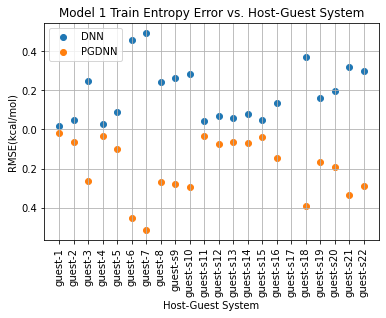

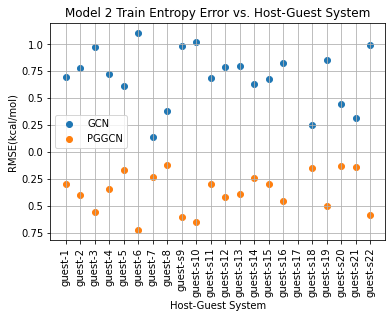

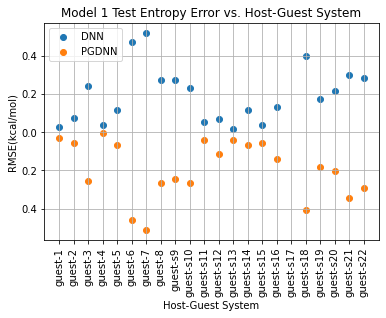

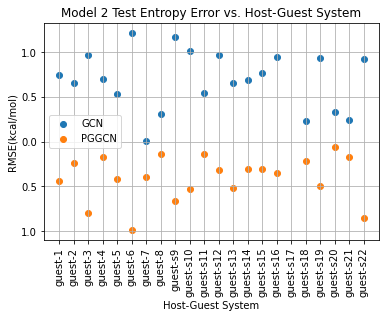

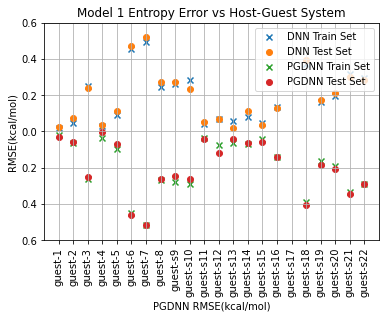

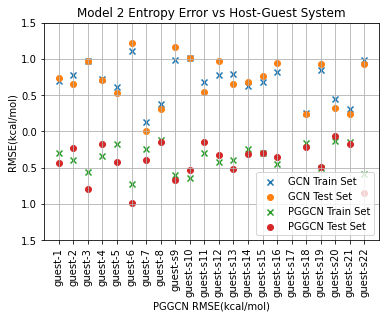

In [30]:
# convert the extracted data into something that matplot lib likes
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import numpy as np

# to get rid of negative signs in y axis, we'll use tick formatter
@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str(round(abs(-x), 2)) if x < 0 else str(round(x,2))
    return label

# model lookup info for this figure
model_lookup = {
        'pure': {
            'Circular Fingerprint': 'DNN',
            'Graph Conv Featurizer': 'GCN',
            'Modded Graph Conv Featurizer': 'PGGCN-Lite',
            'Modded Circular Fingerprint': 'PGDNN-Lite'
        },
        'vm2': {
            'Circular Fingerprint': 'Min DNN',
            'Graph Conv Featurizer': 'Min GCN',
            'Modded Graph Conv Featurizer': 'PGGCN',
            'Modded Circular Fingerprint': 'PGDNN'
        }
}

# Generate a new figure
labels = []
x = []
y = []
xtick_to_system = {}
figures = {}

# setup for this collection run
for index, ( structure, expected_val ) in enumerate( experimental_data.items() ):
  x.append(index)
  labels.append(structure)
  xtick_to_system[structure] = index
  y.append(0)

# desired pairs
pairs = [
    [ 
        ('pure', 'Circular Fingerprint'),
        ('vm2', 'Modded Circular Fingerprint')
    ],
    #
    [
        ('pure', 'Graph Conv Featurizer'),
        ('vm2', 'Modded Graph Conv Featurizer')
    ]
]

# datasets
use_data = [
    ('Train', extracted_data_by_guest_train ),
    ('Test', extracted_data_by_guest_test)
]

# Generate the Error by Guest Plots
for (data_str, data) in use_data:
  for pair in pairs:
    for dock_type, model_type in pair:
      # only create a NEW plot on non-modified features
      if 'Modded' in model_type:
        print(f'MODDED! loaded previously generated figure {model_type}')
        if 'Circular' in model_type:
          fig, ax = figures['Circular Fingerprint']
        elif 'Graph Conv Featurizer' in model_type:
          fig, ax = figures['Graph Conv Featurizer']
      else:
        # plot using matplot lib
        # we'll collect data per fold as well to graph out!
        fig, ax = plt.subplots()
        ax.legend()
        ax.grid(True)
        ax.yaxis.set_major_formatter(major_formatter)
        figures[model_type] = (fig, ax)
        plt.xticks(x, labels, rotation='vertical', label='physical')
        ax.set_ylabel('RMSE(kcal/mol)')
        ax.set_xlabel('Host-Guest System')
        title = 'Model 1' if 'Circular Fingerprint' in model_type else 'Model 2'
        ax.set_title(f'{title} {data_str} Entropy Error vs. Host-Guest System')

        print( f'created figure for {model_type}' )

      for id, value in data[dock_type][model_type].items():
        y[ xtick_to_system[id] ] = numpy.average(value) if 'Modded' not in model_type else -1*numpy.average(value)

      print(model_lookup[dock_type][model_type])
      ax.scatter(x,y,label=model_lookup[dock_type][model_type])

    for model_type, (fig, ax) in figures.items():
      ax.legend()
      fig.savefig(f'error_by_guest_{data_str}_{model_type}.png')

# Finally a version with both bits of data on one plot

# empty out figure info vars
figures = {}

for fig_index, pair in enumerate( pairs ):
  # plot using matplot lib
  # we'll collect data per fold as well to graph out!
  plt.xticks(x, labels, rotation='vertical', label='physical')
  fig, ax = plt.subplots()
  plt.xticks(x, labels, rotation='vertical', label='physical')
  ax.grid(True)
  # enable legend and limiting of axesE
  ax.yaxis.set_major_formatter(major_formatter)
  figures[fig_index] = (fig, ax)

  for dock_type, model_type in pair:
    
    for index, ( data_str, data ) in enumerate(use_data):
      # only create a NEW plot on non-modified features
      for id in experimental_data.keys():
        val = numpy.average(data[dock_type][model_type][id])
        y[ xtick_to_system[id] ] = val if 'Modded' not in model_type else -1*val

        ax.set_xlabel(f'{model_lookup[dock_type][model_type]} RMSE(kcal/mol)')

      if index == 0:
        ax.scatter(x,y, label=f'{model_lookup[dock_type][model_type]} Train Set', marker='x')
      else: # index != 0
        ax.scatter(x,y, label=f'{model_lookup[dock_type][model_type]} Test Set', marker='o')
    
  print( f'created figure for {model_lookup[dock_type][model_type]}' )

for fig_index, (fig, ax) in figures.items():
  if fig_index == 0:
    ax.set_title(f'Model 1 Entropy Error vs Host-Guest System')
    ax.set_ylim(ymin=-0.6, ymax=0.6)
  else: # fig_index != 0
    ax.set_title(f'Model 2 Entropy Error vs Host-Guest System')
    ax.set_ylim(ymin=-1.5, ymax=1.5)

  # enable legend and limiting of axes
  ax.set_xlim(xmin=-1, xmax=22)
  ax.set_ylabel('RMSE(kcal/mol)')
  ax.legend()
  #ax.add_line(mlines.Line2D([0, 21], [0,0],color='black'))
  fig.savefig(f'error_{fig_index}.png')

We'll do a correlation plot 

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
created figure for Circular Fingerprint
1
MODDED! loaded previously generated figure Modded Circular Fingerprint
PGDNN
0
created figure for Graph Conv Featurizer
1
MODDED! loaded previously generated figure Modded Graph Conv Featurizer
PGGCN


0
created figure for Circular Fingerprint
1
MODDED! loaded previously generated figure Modded Circular Fingerprint
PGDNN
0
created figure for Graph Conv Featurizer
1
MODDED! loaded previously generated figure Modded Graph Conv Featurizer
PGGCN
created figure for PGDNN
created figure for PGGCN


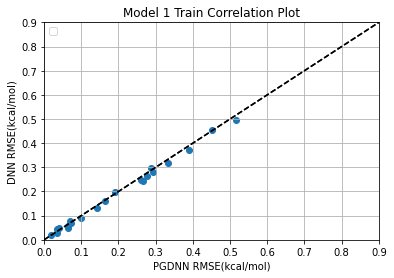

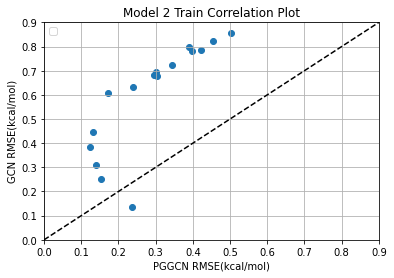

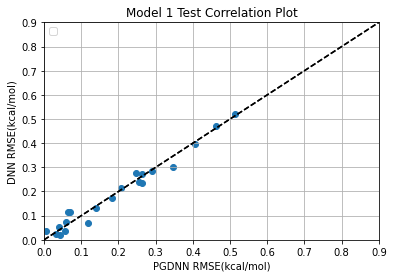

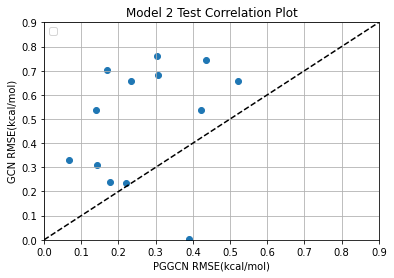

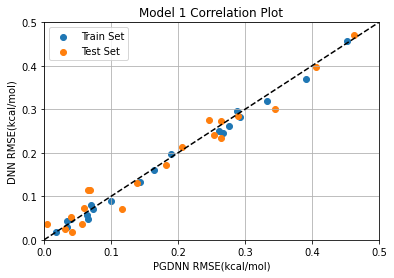

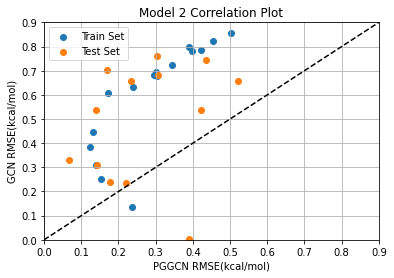

In [25]:
# convert the extracted data into something that matplot lib likes
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import numpy as np

# to get rid of negative signs in y axis, we'll use tick formatter
@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str(round(abs(-x), 2)) if x < 0 else str(round(x,2))
    return label

# model lookup info for this figure
model_lookup = {
        'pure': {
            'Circular Fingerprint': 'DNN',
            'Graph Conv Featurizer': 'GCN',
            'Modded Graph Conv Featurizer': 'PGGCN-Lite',
            'Modded Circular Fingerprint': 'PGDNN-Lite'
        },
        'vm2': {
            'Circular Fingerprint': 'Min DNN',
            'Graph Conv Featurizer': 'Min GCN',
            'Modded Graph Conv Featurizer': 'PGGCN',
            'Modded Circular Fingerprint': 'PGDNN'
        }
}

# Generate a new figure
labels = []
x = []
y = []
xtick_to_system = {}
figures = {}

# setup for this collection run
for index, ( structure, expected_val ) in enumerate( experimental_data.items() ):
  x.append(index)
  labels.append(structure)
  xtick_to_system[structure] = index
  y.append(0)

# desired pairs
pairs = [
    [ 
        ('pure', 'Circular Fingerprint'),
        ('vm2', 'Modded Circular Fingerprint')
    ],
    #
    [
        ('pure', 'Graph Conv Featurizer'),
        ('vm2', 'Modded Graph Conv Featurizer')
    ]
]

# datasets
use_data = [
    ('Train', extracted_data_by_guest_train ),
    ('Test', extracted_data_by_guest_test)
]

# Generate the corelation plots based on the pairs above
for (data_str, data) in use_data:
  # empty out figure info vars
  figures = {}

  for pair in pairs:
    x = []
    y = []
    for index, (dock_type, model_type) in enumerate(pair):
      print(index)
      # only create a NEW plot on non-modified features
      if index == 1:
        print(f'MODDED! loaded previously generated figure {model_type}')
        if 'Circular' in model_type:
          fig, ax = figures['Circular Fingerprint']
        elif 'Graph Conv Featurizer' in model_type:
          fig, ax = figures['Graph Conv Featurizer']

        for id in experimental_data.keys():
          val = numpy.average(data[dock_type][model_type][id])
          x.append(val)

        ax.set_xlabel(f'{model_lookup[dock_type][model_type]} RMSE(kcal/mol)')

      else: # index == 0
        # plot using matplot lib
        # we'll collect data per fold as well to graph out!
        fig, ax = plt.subplots()
        ax.legend()
        ax.grid(True)
        ax.yaxis.set_major_formatter(major_formatter)
        figures[model_type] = (fig, ax)
        
        ax.set_ylabel(f'{model_lookup[dock_type][model_type]} RMSE(kcal/mol)')
        title = 'Model 1' if 'Circular Fingerprint' in model_type else 'Model 2'
        ax.set_title(f'{title} {data_str} Correlation Plot')

        for id in experimental_data.keys():
          val = numpy.average(data[dock_type][model_type][id])
          y.append(val)

        print( f'created figure for {model_type}' )

    print(model_lookup[dock_type][model_type])
    ax.scatter(x,y)

    for model_type, (fig, ax) in figures.items():
      ax.add_line(mlines.Line2D([0, 1], [0,1], linestyle='--',color='black'))
      plt.ylim([0, 0.9])
      plt.xlim([0, 0.9])
      fig.savefig(f'corel_{data_str}_{model_type}.png')

# Finally a version with both bits of data on one plot

# empty out figure info vars
figures = {}

for fig_index, pair in enumerate( pairs ):
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  
  # plot using matplot lib
  # we'll collect data per fold as well to graph out!
  fig, ax = plt.subplots()
  ax.grid(True)
  # enable legend and limiting of axesE
  ax.yaxis.set_major_formatter(major_formatter)
  figures[fig_index] = (fig, ax)

  title = 'Model 1' if fig_index == 0 else 'Model 2'
  ax.set_title(f'{title} Correlation Plot')

  for index, ( dock_type, model_type ) in  enumerate( pair ):

    for data_str, data in use_data:
      # only create a NEW plot on non-modified features
      if index == 1:
        for id in experimental_data.keys():
          val = numpy.average(data[dock_type][model_type][id])
          x_train.append(val) if data_str == 'Train' else x_test.append(val)

        ax.set_xlabel(f'{model_lookup[dock_type][model_type]} RMSE(kcal/mol)')

      else: # index == 0
        ax.set_ylabel(f'{model_lookup[dock_type][model_type]} RMSE(kcal/mol)')

        for id in experimental_data.keys():
          val = numpy.average(data[dock_type][model_type][id])
          y_train.append(val) if data_str == 'Train' else y_test.append(val)
  
  ax.scatter(x_train,y_train, label='Train Set')
  ax.scatter(x_test,y_test, label='Test Set')
  print( f'created figure for {model_lookup[dock_type][model_type]}' )

for fig_index, (fig, ax) in figures.items():
  if fig_index == 0:
    # enable legend and limiting of axes
    ax.set_ylim(ymin=0, ymax=0.5)
    ax.set_xlim(xmin=0, xmax=0.5)
  else:
    # enable legend and limiting of axes
    ax.set_ylim(ymin=0, ymax=0.9)
    ax.set_xlim(xmin=0, xmax=0.9)
  ax.legend()
  ax.add_line(mlines.Line2D([0, 1], [0,1], linestyle='--',color='black'))
  fig.savefig(f'corel_{data_str}_{fig_index}.png')

In [22]:
final_metrics = defaultdict(dict)

for dock_type, metrics_for_dock in metrics_data.items():
  for featuerizer in metrics_for_dock:
    df = pandas.DataFrame.from_dict(metrics_data[dock_type][featuerizer])
    training = pandas.DataFrame.from_dict( dict(df[0]) )
    test = pandas.DataFrame.from_dict( dict(df[1]) )
    final_metrics[dock_type][featuerizer] = (training, test)

In [23]:
model_lookup = {
    'Circular Fingerprint': 'DNN',
    'Graph Conv Featurizer': 'GCN',
    'Modded Graph Conv Featurizer': 'PGGCN',
    'Modded Circular Fingerprint': 'PGDNN'
}

K = 10

print('Pure Based Data (physics guided)')
for model, (training_data, test_data) in final_metrics['pure'].items():
  if 'Modded' in model:
    continue
  print(f'{model_lookup[model]} folded {K} times: Mean')
  print(training_data.mean(axis=1))
  print(training_data.std(axis=1))
  print(test_data.mean(axis=1))
  print(test_data.std(axis=1))

print('VM2 Based Data (physics guided)')
for model, (training_data, test_data) in final_metrics['vm2'].items():
  if 'Modded' not in model:
    continue
  print(f'{model_lookup[model]} folded {K} times: Mean')
  print(training_data.mean(axis=1))
  print(training_data.std(axis=1))
  print(test_data.mean(axis=1))
  print(test_data.std(axis=1))

Pure Based Data (physics guided)
DNN folded 10 times: Mean
rms_score    0.328129
dtype: float64
rms_score    0.124718
dtype: float64
rms_score    0.210795
dtype: float64
rms_score    0.07192
dtype: float64
GCN folded 10 times: Mean
rms_score    0.976599
dtype: float64
rms_score    0.133867
dtype: float64
rms_score    0.95068
dtype: float64
rms_score    0.194746
dtype: float64
VM2 Based Data (physics guided)
PGGCN folded 10 times: Mean
rms_score    0.747496
dtype: float64
rms_score    0.249335
dtype: float64
rms_score    0.616319
dtype: float64
rms_score    0.032441
dtype: float64
PGDNN folded 10 times: Mean
rms_score    0.213122
dtype: float64
rms_score    0.084492
dtype: float64
rms_score    0.177476
dtype: float64
rms_score    0.130189
dtype: float64


Instead of showing a view across all folds as a scatter plot, we'll do it as a box plot with whiskers

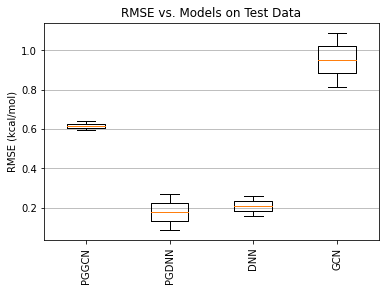

In [24]:
model_lookup = {
    'Circular Fingerprint': 'DNN',
    'Graph Conv Featurizer': 'GCN',
    'Modded Graph Conv Featurizer': 'PGGCN',
    'Modded Circular Fingerprint': 'PGDNN'
}

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# data to reset between runs!
labels = []
x = []
y = []
model_to_ticklabel = {}
counter = 0
model_results = []

for model, (training_data, test_data) in final_metrics['vm2'].items():
  data = []
  if model not in model_to_ticklabel:
    model_to_ticklabel[model_lookup[model]] = counter
    labels.append(model_lookup[model])
    counter += 1

  for trial, item in training_data.iteritems():
    x = model_to_ticklabel[model_lookup[model]]
    y = item
    #data.append(y)

  for trial, item in test_data.iteritems():
    x = model_to_ticklabel[model_lookup[model]]
    y = item
    data.append(y)

  model_results.append(numpy.concatenate(data))

ax.set_ylabel('RMSE (kcal/mol)')
#ax.set_title('RMSE vs. Models across Folds Training Datasets')
ax.set_title('RMSE vs. Models on Test Data')
ax.grid(which='both', axis='y')

for model, (training_data, test_data) in final_metrics['pure'].items():
  data = []

  if model not in labels and model not in model_to_ticklabel:
    model_to_ticklabel[model] = counter
    labels.append(model_lookup[model])
    counter += 1

  for trial, item in training_data.iteritems():
    x = model_to_ticklabel[model]
    y = item
    #data.append(y)

  for trial, item in test_data.iteritems():
    x = model_to_ticklabel[model]
    y = item
    data.append(y)

  model_results.append(numpy.concatenate(data))

ax.boxplot(model_results, showfliers=False)
plt.xticks([x for x in range(1,len(labels)+1)], labels, rotation='vertical', label='physical')
plt.show()

In [ ]:
import pickle
from google.colab import files, drive

drive.mount('/content/drive')

with open("/content/drive/My Drive/final_results_pre_opt.pickle","wb") as f:
  pickle.dump(final_metrics, f)

with open("/content/drive/My Drive/all_losses_pre_opt.pickle","wb") as f:
  pickle.dump(all_losses, f)

Finally we'll do some hyper parameter tuning - we'll use the grid optimization method to search the space of each hyperparameter to find the one that works the best across all folds.


In [ ]:
# Tune against RMSE score
metric = deepchem.metrics.Metric(deepchem.metrics.rms_score, mode='regression')
splitter = deepchem.splits.RandomSplitter()
tuning_results = defaultdict(dict)

def DNN_wrapper(**p):
  model = DNN_Regression_Model(**p)
  dc_model = deepchem.models.TorchModel(model, deepchem.models.losses.L2Loss(), **p)
  return dc_model

def PGDNN_wrapper(**p):
  model = DNN_Regression_Model(input_feature_size=2048+1,**p)
  dc_model = deepchem.models.TorchModel(model, deepchem.models.losses.L2Loss(), **p)
  return dc_model

for dock_type, input_datasets in datasets.items():
  for featureizer_type, dataset in input_datasets.items():
    print(f'tuning with data from {dock_type} for: {featureizer_type}')
    
    # Will be populated based on Featurizer/Model Type
    optimizer = None
    params_dict = None

    if featureizer_type == 'Circular Fingerprint':
      optimizer = deepchem.hyper.GridHyperparamOpt(DNN_wrapper)
      params_dict = \
      {
          "dropout": [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
          "learning_rate": [ 1 / 10 ** n for n in range(3, 6) ],
          "layers": [1, 2, 4, 8, 16, 36, 64, 80, 96],
          "units": [50, 100, 200, 400, 800, 1000, 2000, 2048, 3000, 4000, 5000]
      }
      continue
      
    elif featureizer_type == 'Graph Conv Featurizer':
      optimizer = deepchem.hyper.GridHyperparamOpt\
      (
          lambda **p: deepchem.models.GCNModel(n_tasks=1, number_atom_features=30, mode="regression", **p)
      )
      params_dict = \
      {
          "dropout": [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
          "predictor_dropout": [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
          "learning_rate": [ 1 / 10 ** n for n in range(3, 6) ],
          "predictor_hidden_feats": [ 128 * n for n in range(1,6)]
      }
      continue

    elif featureizer_type == 'Modded Graph Conv Featurizer':
      optimizer = deepchem.hyper.GridHyperparamOpt\
      (
          lambda **p: deepchem.models.GCNModel(n_tasks=1, number_atom_features=31, mode="regression", **p)
      )
      params_dict = \
      {
          "dropout": [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
          "predictor_dropout": [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
          "learning_rate": [ 1 / 10 ** n for n in range(3, 6) ],
          "predictor_hidden_feats": [ 128 * n for n in range(1,6)]
      }

    elif featureizer_type == 'Modded Circular Fingerprint':
      optimizer = deepchem.hyper.GridHyperparamOpt(PGDNN_wrapper)
      params_dict = \
      {
          "dropout": [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
          "learning_rate": [ 1 / 10 ** n for n in range(3, 6) ],
          "layers": [1, 2, 4, 8, 16, 36, 64, 80, 96],
          "units": [50, 100, 200, 400, 800, 1000, 2000, 2048, 3000, 4000, 5000]
      }

    # Dataset info for this model
    train, test = splitter.train_test_split(dataset)

    best_model, best_params, all_results = optimizer.hyperparam_search\
    (
        params_dict=params_dict, 
        train_dataset=train, 
        valid_dataset=test, 
        metric=metric, 
        nb_epoch=100
    )
    print(f'tuned {dock_type} {featureizer_type} to {best_params}')
    tuning_results[dock_type][featureizer_type] = (best_model, best_params, all_results)

Now print out the actual Hyperparameter optimized values. Note, the featurizer is different depending on the dock_type!

In [ ]:
for dock_type, input_datasets in datasets.items():
  for featureizer_type in tuning_results[dock_type].keys():
    (best_model, best_params, all_results ) = tuning_results[dock_type][featureizer_type]
    print( f'{dock_type} {featureizer_type} {best_params}' )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


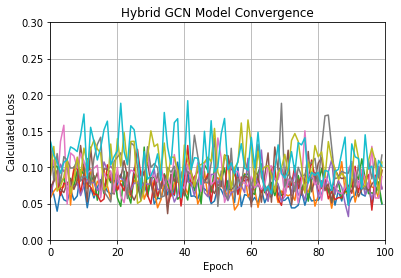

In [26]:
from matplotlib import animation, rc, pyplot
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
#for loss_data in losses['vm2']['Graph Conv Featurizer']
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][9], label='fold 10')
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][8], label='fold 9')
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][7], label='fold 8')
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][6], label='fold 7')
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][5], label='fold 6')
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][4], label='fold 5')
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][3], label='fold 4')
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][2], label='fold 3')
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][1], label='fold 2')
pyplot.plot(losses['vm2']['Modded Graph Conv Featurizer'][0], label='fold 0')
pyplot.title('Hybrid GCN Model Convergence')
pyplot.axes().set_xlabel('Epoch')
pyplot.axes().set_ylabel('Calculated Loss')
#pyplot.legend()
pyplot.ylim([0, 0.30])
pyplot.xlim([0, 100])
pyplot.grid(True)
pyplot.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


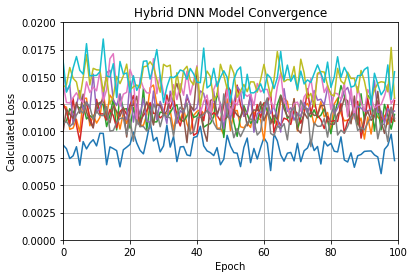

In [27]:
from matplotlib import animation, rc, pyplot
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
#for loss_data in losses['vm2']['Graph Conv Featurizer']
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][9], label='fold 10')
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][8], label='fold 9')
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][7], label='fold 8')
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][6], label='fold 7')
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][5], label='fold 6')
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][4], label='fold 5')
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][3], label='fold 4')
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][2], label='fold 3')
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][1], label='fold 2')
pyplot.plot(losses['vm2']['Modded Circular Fingerprint'][0], label='fold 1')
pyplot.title('Hybrid DNN Model Convergence')
pyplot.axes().set_xlabel('Epoch')
pyplot.axes().set_ylabel('Calculated Loss')
pyplot.ylim([0, 0.020])
pyplot.xlim([0, 100])
pyplot.grid(True)
#pyplot.legend()
pyplot.show()

What made fold 4 for the PGGCN and fold 1 for the DNN special?

In [36]:
for model, network_data in dataset_data.items():
  for network_type, network_trials in network_data.items():
    for fold_id, fold_datasets in network_trials.items():
      training_set, testing_set = fold_datasets
      print( f'training set for {network_type} for fold {fold_id}', training_set.ids )
      print( f'test set for {network_type} for fold {fold_id}', testing_set.ids )

training set for Modded Graph Conv Featurizer for fold 0 ['guest-5' 'guest-2' 'guest-8' 'guest-s10' 'guest-s11' 'guest-s21'
 'guest-7' 'guest-s14' 'guest-3' 'guest-4' 'guest-1' 'guest-s15'
 'guest-s19' 'guest-s18' 'guest-s16' 'guest-s13' 'guest-s20' 'guest-s12'
 'guest-s9']
test set for Modded Graph Conv Featurizer for fold 0 ['guest-6' 'guest-s22']
training set for Modded Graph Conv Featurizer for fold 1 ['guest-6' 'guest-s22' 'guest-s14' 'guest-s16' 'guest-7' 'guest-s12'
 'guest-s21' 'guest-8' 'guest-s11' 'guest-s13' 'guest-s20' 'guest-s19'
 'guest-1' 'guest-s9' 'guest-s18' 'guest-s15' 'guest-s10' 'guest-4'
 'guest-2']
test set for Modded Graph Conv Featurizer for fold 1 ['guest-3' 'guest-5']
training set for Modded Graph Conv Featurizer for fold 2 ['guest-6' 'guest-s22' 'guest-3' 'guest-5' 'guest-s15' 'guest-s10'
 'guest-s12' 'guest-s20' 'guest-s11' 'guest-s21' 'guest-s19' 'guest-7'
 'guest-s9' 'guest-2' 'guest-8' 'guest-s18' 'guest-s14' 'guest-4'
 'guest-s16']
test set for Modded G

Oddly enough, what seperates the models here from great performance appears to be Guest S17, removing this from the dataset! Let's see if the models converge better?

Using the optimized models, see how the better models perform.

In [ ]:
for model, results  in tuning_results.items():
  for model_type, result in results.items():
    (best_model, best_params, all_results) = result
    print(f'{model_type} best params', best_params)

Modded Graph Conv Featurizer best params {'dropout': 0.2, 'predictor_dropout': 0.2, 'learning_rate': 0.0001, 'predictor_hidden_feats': 640}
Modded Circular Fingerprint best params {'dropout': 0.9, 'learning_rate': 0.001, 'layers': 1, 'units': 2000}


In [ ]:
# Pure Data Driven (would be top)
# No docking or anything else

optimized_DNN_VINA_model = DNN_wrapper(log_frequency=1, **tuning_results['vina']['Circular Fingerprint'][1])
optimized_GCN_VINA_model = deepchem.models.GCNModel(n_tasks=1, number_atom_features=30, mode="regression", log_frequency=1, **tuning_results['vina']['Graph Conv Featurizer'][1])

# slightly more physics
optimized_DNN_VM2_model = DNN_wrapper(**tuning_results['vm2']['Circular Fingerprint'][1])
optimized_GCN_VM2_model = deepchem.models.GCNModel(n_tasks=1, number_atom_features=30, mode="regression", log_frequency=1, **tuning_results['vm2']['Graph Conv Featurizer'][1])

# pure hybird
optimized_PGGCN_VM2_model = deepchem.models.GCNModel(n_tasks=1, number_atom_features=31, mode="regression", log_frequency=1, **tuning_results['vm2']['Modded Graph Conv Featurizer'][1])
optimized_PGDNN_VM2_model = PGDNN_wrapper(log_frequency=1, **tuning_results['vm2']['Modded Circular Fingerprint'][1])

# pure physics
# VM2

In [ ]:
opt_losses = defaultdict(dict)

metrics_data = defaultdict(dict)

for dock_type, input_datasets in datasets.items():
  for featureizer_type, dataset in input_datasets.items():
    print(f'training with data from {dock_type} for: {featureizer_type}')
    model = None # Will be populated based on Featurizer
    
    if featureizer_type == 'Circular Fingerprint' and dock_type == 'vm2':
      model = optimized_DNN_VM2_model
    elif featureizer_type == 'Circular Fingerprint' and dock_type == 'vina':
      model = optimized_DNN_VINA_model

    elif featureizer_type == 'Graph Conv Featurizer' and dock_type == 'vm2':
      model = optimized_GCN_VM2_model
    elif featureizer_type == 'Graph Conv Featurizer' and dock_type == 'vina':
      model = optimized_GCN_VINA_model

    elif featureizer_type == 'Modded Graph Conv Featurizer':
      model = optimized_PGGCN_VM2_model

    elif featureizer_type == 'Modded Circular Fingerprint':
      model = optimized_PGDNN_VM2_model

    elif featureizer_type == 'Linear Regression':
      model = linear_model
    
    # instead of doing a single test/train split, we'll do folding instead
    #train_dataset, test_dataset = splitter.train_test_split(dataset)

    # We'll collect the folds, and perfold, train / Eval the model
    folds = splitter.k_fold_split(dataset, K)
    fold_id = 0
    metrics_data[dock_type][featureizer_type] = []
    opt_losses[dock_type][featureizer_type] = defaultdict(list)

    for fold_dataset in folds:
      fold_id += 1
      train_dataset, test_dataset = fold_dataset
      if 'Linear Regression' not in featureizer_type:
        model.fit(train_dataset, nb_epoch=100, all_losses=opt_losses[dock_type][featureizer_type][fold_id])
      else:
        model.fit(train_dataset)

      # record the data for extraction later
      metrics_data[dock_type][featureizer_type].append((model.evaluate(train_dataset, metrics),model.evaluate(test_dataset, metrics)))

      # print out the metrics for user
      #print(f'Performance on training set, fold {fold_id}:', model.evaluate(train_dataset, metrics))
      #print(f'Performance on testing set, fold {fold_id}:', model.evaluate(test_dataset, metrics))

      print(f'collected data for fold {fold_id}')

training with data from vm2 for: Circular Fingerprint
collected data for fold 1
collected data for fold 2
collected data for fold 3
collected data for fold 4
collected data for fold 5
training with data from vm2 for: Graph Conv Featurizer


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 1


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 2


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 3


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 4


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 5
training with data from vm2 for: Modded Graph Conv Featurizer


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 1


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 2


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 3


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 4


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 5
training with data from vm2 for: Modded Circular Fingerprint
collected data for fold 1
collected data for fold 2
collected data for fold 3
collected data for fold 4
collected data for fold 5
training with data from vina for: Circular Fingerprint
collected data for fold 1
collected data for fold 2
collected data for fold 3
collected data for fold 4
collected data for fold 5
training with data from vina for: Graph Conv Featurizer


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 1


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 2


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 3


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 4


/usr/local/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


collected data for fold 5


In [ ]:
final_metrics = defaultdict(dict)

for dock_type, metrics_for_dock in metrics_data.items():
  for featuerizer in metrics_for_dock:
    df = pandas.DataFrame.from_dict(metrics_data[dock_type][featuerizer])
    training = pandas.DataFrame.from_dict( dict(df[0]) )
    test = pandas.DataFrame.from_dict( dict(df[1]) )
    final_metrics[dock_type][featuerizer] = (training, test)

In [ ]:
tuning_results['vm2']['Modded Circular Fingerprint'][1]

{'dropout': 0.0, 'learning_rate': 0.001, 'layers': 151, 'units': 2000}

In [ ]:
opt_losses



---
Future Work! Replacment of the Loss function with a Physics guided version.
Up until now we've basically done 1/2 of what a regular physics guided network does. We've introduced a feature that's calculated from a regular physics model. However, to fully realize the knowledged in a regular physics model, we should encourage the nueral network to favor following gradients that are physically consistent. This is what the below is all about!


Loss function/objective function is a key element of a physics informed/derived neural network. The loss function will include elements related to physics properties of entropy calculations.
The idea here is to imbue some knowledge into how the loss function functions beyond looking at prediction and ground truth - ideally resulting in a quicker convergence of the overall model enabling lower volume of data needed to train the network.
We'll also be using data training techiques to further stretch what data we have further - in order to create the most general model possible. Our goal is to do Leave One Out Cross Validation with the data we have.

In [ ]:
class PhysicsGuidedLoss(deepchem.models.losses.Loss):
  # This Loss function does L2Loss along with some Physics Guided
  # consistency parameters to enable rapid convergence with the
  # limited dataset we have to train on.

  def _compute_tf_loss(self, output, labels):
    import tensorflow as tf
    output, labels = _make_tf_shapes_consistent(output, labels)
    output, labels = _ensure_float(output, labels)
    return tf.square(output - labels)

  def _create_pytorch_loss(self):
    import torch

    def loss(output, labels):
      output, labels = _make_pytorch_shapes_consistent(output, labels)
      return torch.nn.functional.mse_loss(output, labels, reduction='none')

    return loss

Finally, we wrap this into an actual deep chem model - which couples the loss function with the rest of the network. 
The Deepchem model is designed to work with the rest of the deepchem tool set (including training, batching, etc)

In [ ]:
#model = deepchem.models.TorchModel(pytorch_model, PhysicsGuidedLoss())

Until we have the loss function set up to be physics guided - we'll just add in physics features into the input vector space. What this means is that 